# numba CUDA와 pycuda 속도 비교

In [10]:
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 150

import subprocess

from numpy import linalg
import time

### Serial code for Laplace Equation

In [11]:
def jacobi(n, ti, dt):
    """
    Jacobi method
    
    Parameters
    ----------
    n : integer
        size
    ti : float
        current time
    dt : array
        difference
    """
    for i in range(1, n+1):
        for j in range(1, n+1):
            dt[i, j] = 0.25*(ti[i-1, j] + ti[i, j-1] + ti[i+1, j] + ti[i, j+1]) - ti[i, j]
            
def jacobi_v1(ti, dt):
    """
    Jacobi method (Vector version)
    
    Parameters
    ----------
    n : integer
        size
    ti : float
        current time
        
    Parameters
    -----------
    dt : array
        difference
    """
    dt[1:-1, 1:-1] = 0.25*(ti[:-2, 1:-1] + ti[1:-1, :-2] + ti[2:, 1:-1] + ti[1:-1, 2:]) - ti[1:-1, 1:-1]

def bc(t):
    t[-1, 1:-1] = 300   # upper side
    t[0, 1:-1] = 100    # lower side
    t[1:-1, -1] = 100   # Right
    t[1:-1, 0] = 100    # Left

In [12]:
def Laplace_serial(n, tol):

    ti = np.zeros((n+2, n+2))
    dt = np.zeros((n+2, n+2))
            
    err = 1
    hist_jacobi = []

    while err > tol:
        # Apply BC
        bc(ti)
        
        # Run Jacobi
        #jacobi(n, ti, dt)
        jacobi_v1(ti, dt)
        
        # Compute Error
        err = linalg.norm(dt) / n
        hist_jacobi.append(err)
        
        # Update solution
        ti += dt

    return ti

In [13]:
ns = np.arange(30,127,8)
tol = 1e-4
time_serial =[]

for n in ns:
    t_s_gpu = time.time()
    Laplace_serial(n, tol)
    t_e_gpu = time.time()
    time_serial.append(t_e_gpu - t_s_gpu)


In [15]:
subprocess.run(["python", "Laplace_numba.py"])
time_numba = np.load("time_numba.npy")

In [16]:
subprocess.run(["python", "Laplace_pycuda.py"])
time_pycuda = np.load("time_pycuda.npy")

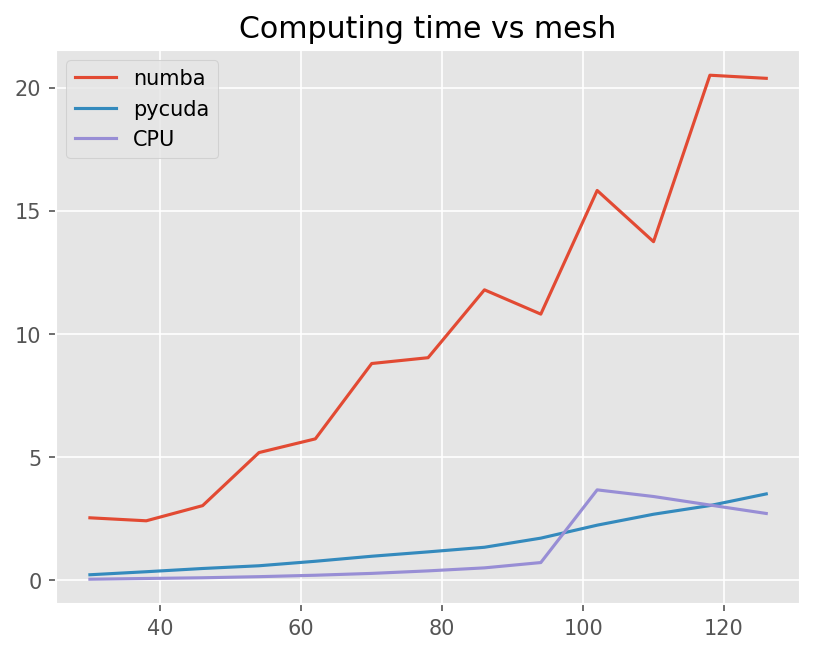

In [17]:
plt.title("Computing time vs mesh")
plt.plot(ns, time_numba, label = "numba")
plt.plot(ns, time_pycuda, label = "pycuda")
plt.plot(ns, time_serial, label = "CPU")
plt.grid(True)
plt.legend()
plt.show()

In [18]:
ns = [126, 254, 510]
tol = 1e-4
time_serial =[]

for n in ns:
    t_s_serial = time.time()
    Laplace_serial(n, tol)
    t_e_serial = time.time()
    time_serial.append(t_e_serial - t_s_serial)

In [21]:
subprocess.run(["python", "Laplace_pycuda.py"])
time_pycuda = np.load("time_pycuda_big.npy")

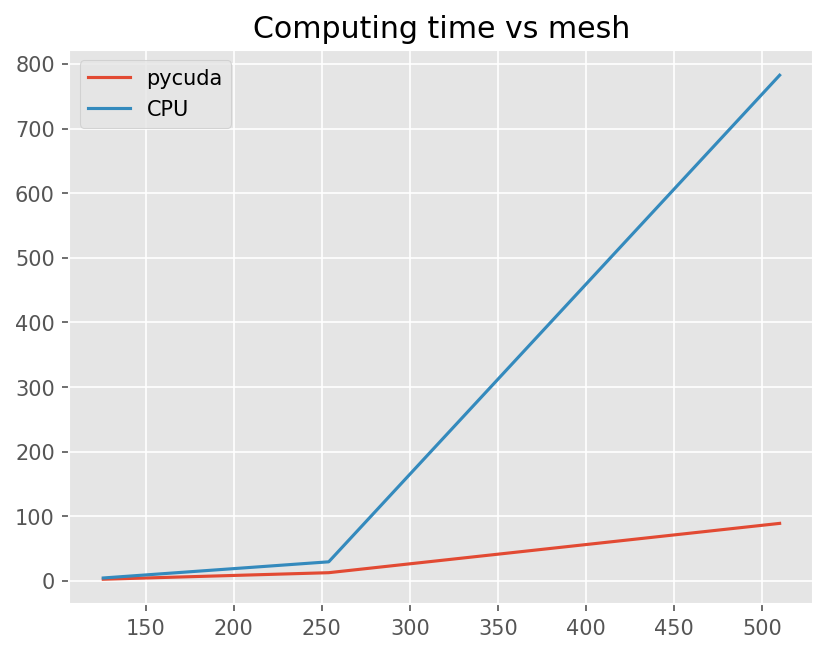

In [22]:
plt.title("Computing time vs mesh")
plt.plot(ns, time_pycuda, label = "pycuda")
plt.plot(ns, time_serial, label = "CPU")
plt.grid(True)
plt.legend()
plt.show()